In [73]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

In [74]:
#data
df=pd.read_csv('C:\Kate\Python\Authorship Attribution\data\AllTweets.csv')
len(df)

88625

In [75]:
pd.DataFrame(df.groupby('author').size().rename('counts')).sort_values('counts', ascending=False)

,counts
author,
DonaldTrump,17216
NASA,15910
KimKardashian,10688
various,10440
FiveThirtyEight,9761
BarackObama,6896
RichardDawkins,5839
AdamSavage,4872
HillaryClinton,3356


In [76]:
#data pre-processing
df.drop(df[df.retweet==True].index, inplace=True)
df['num_of_words'] = df["text"].str.split().apply(len)
df.drop(df[df.num_of_words<4].index, inplace=True)
df["text"].replace(r"http\S+", "URL", regex=True,inplace=True)
df["text"].replace(r"@\S+", "REF", regex=True ,inplace=True)
df["text"].replace(r"(\d{1,2})[/.-](\d{1,2})[/.-](\d{2,4})+", "DATE", regex=True,inplace=True)
df["text"].replace(r"(\d{1,2})[/:](\d{2})[/:](\d{2})?(am|pm)+", "TIME", regex=True,inplace=True)
df["text"].replace(r"(\d{1,2})[/:](\d{2})?(am|pm)+", "TIME", regex=True,inplace=True)
df["text"].replace(r"\d+", "NUM", regex=True,inplace=True)
len(df)

83585

In [77]:
import random
from sklearn.cross_validation import train_test_split
#1000 random sample rows for each author
df_new=pd.DataFrame()
twts_train=pd.DataFrame()
twts_test=pd.DataFrame()
author_train=pd.DataFrame()
author_test=pd.DataFrame()
for a in df.author.unique():
    rows = random.sample(list(df[df['author']==a].index), 1000)
    df_temp = df.ix[rows]
    df_new=df_new.append(df_temp,ignore_index=True)    
    X_train, X_test, Y_train, Y_test = train_test_split(df_temp.ix[:,['text']], df_temp.ix[:,['author']], test_size=0.2, random_state=42)
    twts_train=twts_train.append(X_train, verify_integrity=False)
    twts_test=twts_test.append(X_test, verify_integrity=False)
    author_train=author_train.append(Y_train, verify_integrity=False)
    author_test=author_test.append(Y_test, verify_integrity=False)

Train set:

In [78]:
print (len(twts_train),len(author_train))

(8800, 8800)


Test set:

In [79]:
print(len(twts_test),len(author_test))

(2200, 2200)


In [80]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    3. Stems
    4. Returns a list of the cleaned text
    """

    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    

    return text_processed

In [81]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

In [82]:
ScoreSummaryByModel = list()

In [83]:
def PredictionEvaluation(author_test_b,author_predicted_b,target_names,comment):
    Accuracy=accuracy_score(author_test_b,author_predicted_b)
    #print (Accuracy)
    Recall=recall_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (Recall)
    Precision=precision_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (Precision)
    F1=f1_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (F1)
    ScoreSummaryByModel.append([Accuracy,Recall,Precision,F1,comment])
    print(classification_report(author_test_b, author_predicted_b, target_names=target_names))

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [85]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [86]:
ScoreSummaryByModelParams=list()

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

In [88]:
def ModelParamsEvaluation (f_union,model,params,comment):
    pipeline = Pipeline([
    # Extract the text & text_coded
    # Use FeatureUnion to combine the features from different vectorizers
    ('union', f_union),
    # Use a  classifier on the combined features
    ('clf', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, verbose=1)
    grid_search.fit(twts_train['text'], author_train['author'])
    author_predicted = grid_search.predict(twts_test['text'])
    lb = LabelBinarizer()
    author_test_b = lb.fit_transform(author_test['author'])
    author_predicted_b  = lb.fit_transform(author_predicted)
    #best score
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    author_names=grid_search.best_estimator_.named_steps['clf'].classes_

    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        ScoreSummaryByModelParams.append([comment,grid_search.best_score_,"\t%s: %r" % (param_name, best_parameters[param_name])]) 
    return (author_predicted,author_predicted_b,author_test_b,author_names)

In [89]:
f2_union=FeatureUnion(
        transformer_list=[
            # Pipeline for pulling char features  from the text
            ('char', Pipeline([
                ('tfidf',     TfidfVectorizer(analyzer='char',ngram_range=(3, 3))),
            ])),
            # Pipeline for pulling stememd word features from the text
            ('text', Pipeline([
                ('tfidf',    TfidfVectorizer(analyzer='word',tokenizer= text_process,ngram_range=(1, 1))),
            ])),        

        ],

    )

In [90]:
from sklearn.svm import LinearSVC
#LinearSVC
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,LinearSVC(),p,'LinearSVC')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   38.1s finished


Best score: 0.787
Best parameters set:
	clf__C: 1


In [91]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'LinearSVC')

                 precision    recall  f1-score   support

     AdamSavage       0.63      0.71      0.67       177
    BarackObama       0.82      0.76      0.79       215
    DonaldTrump       0.77      0.77      0.77       200
FiveThirtyEight       0.85      0.80      0.83       213
 HillaryClinton       0.74      0.76      0.75       195
  KimKardashian       0.85      0.81      0.83       211
           NASA       0.89      0.82      0.85       216
 RichardDawkins       0.78      0.81      0.80       192
     ScottKelly       0.79      0.86      0.82       184
  deGrasseTyson       0.80      0.77      0.79       207
        various       0.93      0.97      0.95       190

    avg / total       0.81      0.80      0.81      2200



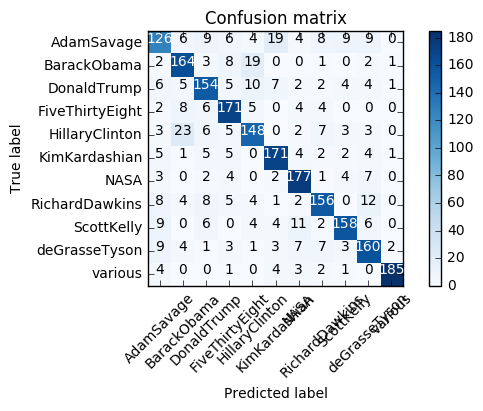

In [92]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [93]:
author_predicted=pd.DataFrame(author_predicted,columns=['predicted'])
df_wrong_result = pd.concat([twts_test.reset_index(),author_test.reset_index(),author_predicted], axis=1)
df_wrong_result.drop('index', axis=1, inplace=True)
df_wrong_result=df_wrong_result[df_wrong_result['author']!=df_wrong_result['predicted']]
df_wrong_result.head(10)

,text,author,predicted
1,"REF No, it's considered lost.",NASA,DonaldTrump
8,LIVE NOW: Often seen as tunnels to other dimen...,NASA,deGrasseTyson
13,How fast will #ClimateChange occur with rising...,NASA,FiveThirtyEight
17,A tale of two extremes: Drenching rains in eas...,NASA,RichardDawkins
18,"REF There is some oxygen on Mars, but it is a ...",NASA,deGrasseTyson
27,Do you speak Italian? REF speaks with Italian...,NASA,deGrasseTyson
35,We stand on the cusp of a new era in aviation ...,NASA,FiveThirtyEight
38,Shuttle Endeavour just did the Terminal Initia...,NASA,deGrasseTyson
56,[Today's Pic] Make a Wish From Space: In honor...,NASA,ScottKelly
66,The March tsunami that struck Japan hit Antarc...,NASA,ScottKelly


In [94]:
df_wrong_result[df_wrong_result['predicted']=='KimKardashian'].head(35)

,text,author,predicted
152,RT REF hiring: Got NUMD graphics programming t...,NASA,KimKardashian
168,RT REF Hi! I am back!!! URL,NASA,KimKardashian
211,Thanks to everyone who voted! We won the Peopl...,AdamSavage,KimKardashian
215,"#NUM: Look at my friend Randi, way back when--...",AdamSavage,KimKardashian
229,Awesome fashion analysis of Rayanne from My So...,AdamSavage,KimKardashian
239,Dave from Power Up did it! I'm back to my game...,AdamSavage,KimKardashian
260,REF You're right! I always liked that sparkle...,AdamSavage,KimKardashian
269,Wanna visit my mancave?URL,AdamSavage,KimKardashian
280,You did it! Congress backpedals HARD on SOPA. ...,AdamSavage,KimKardashian
283,This one URL is my favorite.,AdamSavage,KimKardashian


In [95]:
from sklearn.svm import SVC
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,SVC(kernel='linear'),p,'SVC, linear kernel')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 20.2min finished


Best score: 0.769
Best parameters set:
	clf__C: 1


In [98]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'SVC, linear kernel')

                 precision    recall  f1-score   support

     AdamSavage       0.63      0.63      0.63       201
    BarackObama       0.82      0.77      0.79       213
    DonaldTrump       0.78      0.78      0.78       199
FiveThirtyEight       0.86      0.76      0.81       226
 HillaryClinton       0.74      0.76      0.75       195
  KimKardashian       0.82      0.82      0.82       201
           NASA       0.86      0.87      0.87       197
 RichardDawkins       0.74      0.83      0.79       179
     ScottKelly       0.80      0.87      0.83       184
  deGrasseTyson       0.81      0.74      0.77       221
        various       0.91      0.98      0.94       184

    avg / total       0.80      0.80      0.80      2200



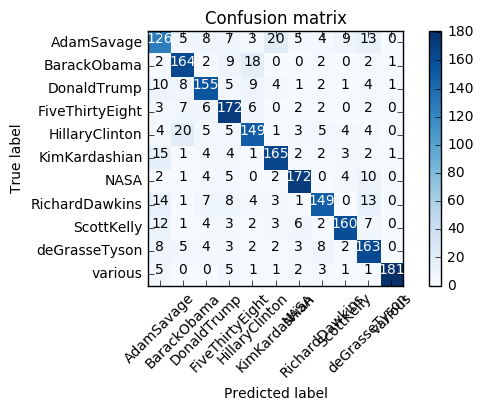

In [99]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [100]:
from sklearn.linear_model import SGDClassifier
p = {'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation (f2_union,SGDClassifier(),p,'SGD Classifier')

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


Best score: 0.783
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'l2'


In [101]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'SGD Classifier')

                 precision    recall  f1-score   support

     AdamSavage       0.59      0.77      0.67       154
    BarackObama       0.83      0.76      0.80       217
    DonaldTrump       0.77      0.75      0.76       203
FiveThirtyEight       0.88      0.79      0.83       222
 HillaryClinton       0.76      0.78      0.77       194
  KimKardashian       0.90      0.77      0.83       233
           NASA       0.87      0.84      0.85       208
 RichardDawkins       0.73      0.85      0.79       172
     ScottKelly       0.80      0.86      0.83       184
  deGrasseTyson       0.81      0.75      0.78       218
        various       0.94      0.97      0.96       195

    avg / total       0.81      0.81      0.81      2200



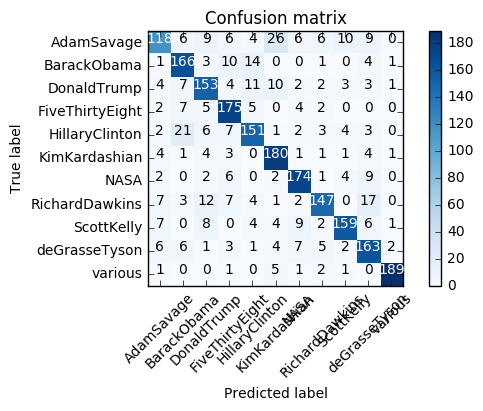

In [102]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [103]:
from sklearn.naive_bayes import BernoulliNB
p = {'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,BernoulliNB(),p,'Bernoulli Naive Bayes')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   38.7s finished


Best score: 0.770
Best parameters set:
	clf__alpha: 0.1


In [104]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'Bernoulli Naive Bayes')

                 precision    recall  f1-score   support

     AdamSavage       0.61      0.77      0.68       159
    BarackObama       0.77      0.81      0.79       191
    DonaldTrump       0.74      0.69      0.72       213
FiveThirtyEight       0.88      0.80      0.84       220
 HillaryClinton       0.73      0.79      0.76       185
  KimKardashian       0.84      0.75      0.80       225
           NASA       0.84      0.84      0.84       202
 RichardDawkins       0.80      0.84      0.82       190
     ScottKelly       0.69      0.70      0.69       197
  deGrasseTyson       0.86      0.76      0.81       228
        various       0.93      0.98      0.95       190

    avg / total       0.80      0.79      0.79      2200



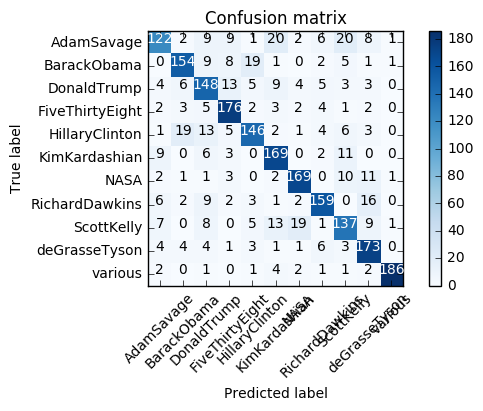

In [105]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In general, the results are worse then without data pre-processing but LinearSVC is still the best

In [106]:
df_ScoreSummaryByModelParams=DataFrame(ScoreSummaryByModelParams,columns=['Method','BestScore','BestParameter'])
df_ScoreSummaryByModelParams.sort_values(['BestScore'],ascending=False,inplace=True)
df_ScoreSummaryByModelParams

,Method,BestScore,BestParameter
0,LinearSVC,0.787045,\tclf__C: 1
2,SGD Classifier,0.783182,\tclf__alpha: 0.0001
3,SGD Classifier,0.783182,\tclf__penalty: 'l2'
4,Bernoulli Naive Bayes,0.769545,\tclf__alpha: 0.1
1,"SVC, linear kernel",0.768523,\tclf__C: 1


In [107]:
df_ScoreSummaryByModel=DataFrame(ScoreSummaryByModel,columns=['Precision','Accuracy','Recall','F1','Comment'])
df_ScoreSummaryByModel.sort_values(['F1'],ascending=False,inplace=True)
df_ScoreSummaryByModel

,Precision,Accuracy,Recall,F1,Comment
3,0.806818,0.808758,0.806818,0.805244,SGD Classifier
0,0.804545,0.804922,0.804545,0.803920,LinearSVC
1,0.798182,0.801644,0.798182,0.798874,"SVC, linear kernel"
2,0.798182,0.801644,0.798182,0.798874,"SVC, linear kernel"
4,0.790455,0.792304,0.790455,0.789504,Bernoulli Naive Bayes
